<a href="https://colab.research.google.com/github/Sat-A/s5-jax/blob/main/s5-tokenised-forecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S5-Tokenised-Forecaster

The goal of this exercise is to adapt an annotated implementation of S5 https://github.com/JPGoodale/annotated-s5 that was made for classification tasks to regression tasks.

# Runtime Setup
Ensure runtime is set to GPU to ensure gpu parallelisation speedup

In [ ]:
!pip install dm-haiku
!pip install hippox
!pip install yfinance
!pip install scikit-learn

In [ ]:
# Let's go ahead and import hippox and the core JAX libraries we will be using:
import jax
import numpy as np
import jax.numpy as jnp
import haiku as hk
from hippox.main import Hippo
from typing import Optional

# New imports for stock data
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# --- NEW: Import KMeans for tokenisation ---
from sklearn.cluster import KMeans

import torch  # Make sure torch is imported if not already
from torch.utils.data import DataLoader, Dataset as TorchDataset
from typing import NamedTuple
import matplotlib.pyplot as plt

First we'll define some helper functions for discretization and timescale initialization as the SSM equation is naturally continuous and must be made discrete to be unrolled as a linear recurrence like standard RNNs.

In [ ]:
# Here we are just using the zero order hold method for its sheer simplicity, with A, B and delta_t denoting the
# state matrix, input matrix and change in timescale respectively.
def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity)) * B
    return _A, _B

# This is a function used to initialize the trainable timescale parameter.
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(shape, dtype):
        uniform = hk.initializers.RandomUniform()
        return uniform(shape, dtype)*(jnp.log(dt_max) - jnp.log(dt_min)) + jnp.log(dt_min)
    return init

# Taken directly from https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/recurrent.py
def add_batch(nest, batch_size: Optional[int]):
    broadcast = lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape)
    return jax.tree_util.tree_map(broadcast, nest)

The linear SSM equation is as follows:
$$ x_0(t) = Ax(t) + Bu(t) $$
$$ y(t) = Cx(t) + Du(t) $$

 We will now implement it as a recurrent Haiku module:

In [ ]:
class LinearSSM(hk.RNNCore):
    def __init__(self, state_size: int, name: Optional[str] = None):
        super(LinearSSM, self).__init__(name=name)
        # We won't get into the basis measure families here, just note that they are basically just the
        # type of orthogonal polynomial we initialize with, the scaled Legendre measure (LegS) introduced
        # in the original HiPPO paper is pretty much the standard initialization and is what is used in the
        # main experiments in the S5 paper. I will also note that the Hippo class uses the diagonal representation
        # of the state matrix by default, as this has become the standard in neural SSMs since shown to be
        # equally effective as the diagonal plus low rank representation in https://arxiv.org/abs/2203.14343
        # and then formalized in https://arxiv.org/abs/2206.11893.

        _hippo = Hippo(state_size=state_size, basis_measure='legs')
        # Must be called for parameters to be initialized
        _hippo()

        # We register the real and imaginary components of the state matrix A as separate parameters because
        # they will have separate gradients in training, they will be conjoined back together and then discretized
        # but this will simply be backpropagated through as a transformation of the lambda real and imaginary
        # parameters (lambda is just what we call the diagonalized state matrix).

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            shape=[state_size,],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            shape=[state_size,],
            init=_hippo.lambda_initializer('imaginary')
        )
        self._A = self._lambda_real + 1j * self._lambda_imag

       # For now, these initializations of the input and output matrices B and C match the S4D
        # parameterization for demonstration purposes, we will implement the S5 versions later.

        self._B = hk.get_parameter(
            'B',
            shape=[state_size,],
            init=_hippo.b_initializer()
        )
        self._C = hk.get_parameter(
            'C',
            shape=[state_size, 2],
            init=hk.initializers.RandomNormal(stddev=0.5**0.5)
        )
        self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        # This feed-through matrix basically acts as a residual connection.
        self._D = hk.get_parameter(
            'D',
            [1,],
            init=jnp.ones,
        )

        self._delta_t = hk.get_parameter(
            'delta_t',
            shape=[1,],
            init=log_step_initializer()
        )
        timescale = jnp.exp(self._delta_t)

        self._state_matrix, self._input_matrix = discretize(self._A, self._B, timescale)

    def __call__(self, inputs, prev_state):
        u = inputs[:, jnp.newaxis]
        new_state = self._state_matrix @ prev_state + self._input_matrix @ u
        y_s = self._output_matrix @ new_state
        out = y_s.reshape(-1).real + self._D * u
        return out, new_state

    def initial_state(self, batch_size: Optional[int] = None):
        state = jnp.zeros([self._state_size])
        if batch_size is not None:
            state = add_batch(state, batch_size)
        return state

You may notice that this looks an awful lot like a vanilla RNN cell, just with our special parameterization and without any activations, hence being a linear recurrence. I have initialized it as an instance of Haiku's RNN.Core abstract base class so that it can be unrolled using either the hk.dynamic_unroll or hk.static_unroll functions like any other recurrent module, however, if you are familiar with any of the S4 models you may be noticing that there's something crucial missing here: the convolutional representation. One of the key contributions of the S4 paper was its demonstration that the SSM ODE can be represented as either a linear recurrence, as above, for efficient inference, or as a global convolution for much faster training. That paper and the following papers then go on to present various kernels for efficiently computing this convolution with Fast Fourier Transforms, highly improving the computational efficiency of the model. Then why have we omitted them? Because the S5 architecture which we are about to explore simplifies all this by providing a purely recurrent representation in both training and inference, it does this by using a parallel recurrence that actually looks alot like a convolution itself! From the paper:

    "We use parallel scans to efficiently compute the states of a discretized linear SSM. Given a binary associative operator • (i.e. (a • b) • c = a • (b • c)) and a sequence of L elements [a1, a2, ..., aL], the scan operation (sometimes referred to as all-prefix-sum) returns the sequence [a1, (a1 • a2), ..., (a1 • a2 • ... • aL)]."

Let's see what this looks like in code, taken straight from the original author's implementation:

In [ ]:
@jax.vmap
def binary_operator(q_i, q_j):
    A_i, b_i = q_i
    A_j, b_j = q_j
    return A_j * A_i, A_j * b_i + b_j

def parallel_scan(A, B, C, inputs):
    A_elements = A * jnp.ones((inputs.shape[0], A.shape[0]))
    Bu_elements = jax.vmap(lambda u: B @ u)(inputs)
    # Jax's built-in associative scan really comes in handy here as it executes a similar scan
    # operation as used in a normal recurrent unroll but is specifically tailored to fit an associative
    # operation like the one described in the paper.
    _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))
    return jax.vmap(lambda x: (C @ x).real)(xs)

It's that simple! In the original S4 we would have had to apply an independent singe-input, single-output (SISO) SSM for each feature of the input sequence such as in this excerpt from Sasha Rush's Flax implementation:



```python
def cloneLayer(layer):
    return flax.linen.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)
```



Whereas in the S5 we process the entire sequence in one multi-input, multi-output (MIMO) layer.

Let's now rewrite our Module as a full S5 layer using this new method, we will be adding a few extra conditional arguments as well as changing some parameterization to match the original paper, but we'll walk through the reason for all these changes below.

In [ ]:
# First we add a new helper function for the timescale initialization, this one just takes the previous
# log_step_initializer and stores a bunch of them in an array since our model is now multi-in, multi-out.
def init_log_steps(shape, dtype):
    H = shape[0]
    log_steps = []
    for i in range(H):
        log_step = log_step_initializer()(shape=(1,), dtype=dtype)
        log_steps.append(log_step)

    return jnp.array(log_steps)

# We will also rewrite our discretization for the MIMO context
def discretize(A, B, delta_t):
    Identity = jnp.ones(A.shape[0])
    _A = jnp.exp(A*delta_t)
    _B = (1/A * (_A-Identity))[..., None] * B
    return _A, _B

In [ ]:
class S5(hk.Module):
    def __init__(self,
                 state_size: int,

                 # Now that we're MIMO we'll need to know the number of input features, commonly
                 # referred to as the dimension of the model.
                 d_model: int,

                 # We must also now specify the number of blocks that we will split our matrices
                 # into due to the MIMO context.
                 n_blocks: int,

                 # Short for conjugate symmetry, because our state matrix is complex we can half
                 # the size of it since complex numbers are a real and imaginary number joined together,
                 # this is not new to the S5, we just didn't mention it above.
                 conj_sym: bool = True,

                 # Another standard SSM argument that we omitted above for simplicity's sake,
                 # this forces the real part of the state matrix to be negative for better
                 # stability, especially in autoregressive tasks.
                 clip_eigns: bool = False,

                 # Like most RNNs, the S5 can be run in both directions if need be.
                 bidirectional: bool = False,

                 # Rescales delta_t for varying input resolutions, such as different audio
                 # sampling rates.
                 step_rescale: float = 1.0,
                 name: Optional[str] = None
    ):
        super(S5, self).__init__(name=name)
        self.conj_sym = conj_sym
        self.bidirectional = bidirectional

        # Note that the Hippo class takes conj_sym as an argument and will automatically half
        # the state size provided in its initialization, which is why we need to provide a local
        # state size that matches this for the shape argument in hk.get_parameter().

        if conj_sym:
            _state_size = state_size // 2
        else:
            _state_size = state_size

        # With block_diagonal set as True and the number of blocks provided, our Hippo class
        # will automatically handle this change of structure.

        _hippo = Hippo(
            state_size=state_size,
            basis_measure='legs',
            conj_sym=conj_sym,
            block_diagonal=True,
            n_blocks=n_blocks,
        )
        _hippo()

        self._lambda_real = hk.get_parameter(
            'lambda_real',
            [_state_size],
            init=_hippo.lambda_initializer('real')
        )
        self._lambda_imag = hk.get_parameter(
            'lambda_imaginary',
            [_state_size],
            init=_hippo.lambda_initializer('imaginary')
        )
        if clip_eigns:
            self._lambda = jnp.clip(self._lambda_real, None, -1e-4) + 1j * self._lambda_imag
        else:
            self._A = self._lambda_real + 1j * self._lambda_imag

        # If you recall, I mentioned above that we are automatically using a diagonalized version of
        # the HiPPO state matrix rather than the pure one, due to it being very hard to efficiently
        # compute. I will now go into a little more detail on how this diagonal representation is
        # derived, as it is important for how we initialize the input and output matrices. The diagonal
        # decomposition of our state matrix is based on equivalence relation on the SSM parameters:
        # (A, B, C) ∼ (V−1AV ,V−1B, CV) with V being the eigenvector of our original A matrix and V-1
        # being the inverse eigenvector. The Hippo class has already performed the decomposition of A
        # into (V-1AV) automatically, but we have not yet performed the decomposition of B and C, we will
        # use the eigenvector_transform class method for that below, but first we must initialize B and C
        # as normal distributions, lecun normal and truncated normal respectively. I will note that there
        # are a few other options provided for C in the original repository but, to keep it simple, we will
        # just use one here.

        b_init = hk.initializers.VarianceScaling()
        b_shape = [state_size, d_model]
        b_init = b_init(b_shape, dtype=jnp.complex64)
        self._B = hk.get_parameter(
            'B',
            [_state_size, d_model, 2],
            init=_hippo.eigenvector_transform(b_init,  concatenate=True),
        )
        B = self._B[..., 0] + 1j * self._B[..., 1]

        c_init = hk.initializers.TruncatedNormal()
        c_shape = [d_model, state_size, 2]
        c_init = c_init(c_shape, dtype=jnp.complex64)
        self._C = hk.get_parameter(
            'C',
            [d_model, _state_size, 2],
            init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
        )
        # We need two output heads if bidirectional is True.
        if bidirectional:
            self._C2 = hk.get_parameter(
                'C2',
                [d_model, _state_size, 2],
                init=_hippo.eigenvector_transform(c_init, inverse=False, concatenate=True),
            )
            C1 = self._C[..., 0] + 1j * self._C[..., 1]
            C2 = self._C2[..., 0] + 1j * self._C2[..., 1]
            self._output_matrix = jnp.concatenate((C1, C2), axis=-1)
        else:
            self._output_matrix = self._C[..., 0] + 1j * self._C[..., 1]

        self._D = hk.get_parameter(
            'D',
            [d_model,],
            init=hk.initializers.RandomNormal(stddev=1.0)
        )

        self._delta_t = hk.get_parameter(
            'delta_T',
            [_state_size, 1],
            init=init_log_steps
        )
        timescale = step_rescale * jnp.exp(self._delta_t[:, 0])

        # We could also use the bilinear discretization method, but we'll just stick to zoh for now.
        self._state_matrix, self._input_matrix = discretize(self._A, B, timescale)


    def __call__(self, inputs):
        # Note that this is the exact same function as presented above just with alternate procedures
        # depending on the bidirectional and conjugate symmetry arguments

        A_elements = self._state_matrix * jnp.ones((inputs.shape[0], self._state_matrix.shape[0]))
        Bu_elements = jax.vmap(lambda u: self._input_matrix @ u)(inputs)

        _, xs = jax.lax.associative_scan(binary_operator, (A_elements, Bu_elements))

        if self.bidirectional:
            _, xs2 = jax.lax.associative_scan(binary_operator,
                                              (A_elements, Bu_elements),
                                              reverse=True)
            xs = jnp.concatenate((xs, xs2), axis=-1)

        if self.conj_sym:
            ys = jax.vmap(lambda x: 2*(self._output_matrix @ x).real)(xs)
        else:
            ys = jax.vmap(lambda x: (self._output_matrix @ x).real)(xs)

        Du = jax.vmap(lambda u: self._D * u)(inputs)

        return ys + Du

There we have it, a complete S5 layer! Now let's form a block around it using a structure very similar to a transformer block with a Gated Linear Unit (GLU).

In [ ]:
import dataclasses

@dataclasses.dataclass
class S5Block(hk.Module):
    ssm: S5
    d_model: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Block, self).__post_init__()
        # We could use either layer norm or batch norm.
        self._norm = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)
        self._linear = hk.Linear(self.d_model)

    def __call__(self, x):
        skip = x
        if self.prenorm:
            x = self._norm(x)

        x = self.ssm(x)
        # There are a couple of other GLU patterns we could use here, but once again I have chosen
        # one semi-arbitrarily to avoid cluttering our module with if statements.
        x1 = hk.dropout(hk.next_rng_key(), self.dropout_rate, jax.nn.gelu(x))
        x = x * jax.nn.sigmoid(self._linear(x1))
        x = hk.dropout(hk.next_rng_key(), self.dropout_rate, x)

        x = skip + x
        if not self.prenorm:
            x = self._norm(x)

        return x

Now let's make a stack of these blocks:

In [ ]:
@dataclasses.dataclass
class S5Stack(hk.Module):
    ssm: S5
    d_model: int
    n_layers: int
    dropout_rate: float
    prenorm: bool
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5Stack, self).__post_init__(name=self.name)
        # --- MODIFIED: Removed the initial hk.Linear encoder ---
        # This role is now filled by the Embedding layer
        self._layers = [
            S5Block(
                ssm=self.ssm,
                d_model=self.d_model,
                dropout_rate=self.dropout_rate,
                istraining=self.istraining,
                prenorm=self.prenorm,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x):
        # --- MODIFIED: Input 'x' is now assumed to be the embedding ---
        for layer in self._layers:
            x = layer(x)
        return x

# Implementing Regression in S5

Create a new dataset class to hold our stock data

In [ ]:
# --- New Data Section ---
# This custom Dataset class will hold our sliding windows
class StockWindowDataset(TorchDataset):
    def __init__(self, data_tokens, label_tokens, last_prices):
        # Data is now integer tokens
        self.data = torch.tensor(np.array(data_tokens), dtype=torch.long)
        self.labels = torch.tensor(np.array(label_tokens), dtype=torch.long)
        # Store the last price of the input window (unscaled)
        self.last_prices = torch.tensor(np.array(last_prices), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Input tokens are now shape [seq_len], no extra feature dim needed
        inputs = self.data[idx]
        last_price = self.last_prices[idx]
        label = self.labels[idx]

        # Return inputs as a tuple (token_sequence, last_price_anchor)
        return (inputs, last_price), label

def create_stock_dataset(batch_size=64, in_seq_length=7, out_seq_length=7, vocab_size=128):
    print(f"[*] Generating Stock Price Dataset (Tokenised Log Returns, Vocab Size={vocab_size})...")

    # 1. Download data
    ticker = "^GSPC"
    data = yf.download(ticker, start="2000-01-01", end="2023-12-31")

    # We'll use 'Close' as the representative "average" price
    prices_flat = data[['Close']].values.flatten()

    # 2. Calculate Log Returns
    log_returns = np.log(prices_flat[1:] / prices_flat[:-1])
    anchor_prices = prices_flat[:-1] # Prices *before* each log return

    # 3. Split into train and test sets (BEFORE tokenising)
    train_split_idx = int(len(log_returns) * 0.8)

    lr_train = log_returns[:train_split_idx]
    lr_test = log_returns[train_split_idx:]

    prices_train = anchor_prices[:train_split_idx]
    prices_test = anchor_prices[train_split_idx:]

    # 4. Tokenise the log returns
    print(f"[*] Fitting KMeans vocabulary on {len(lr_train)} training samples...")
    kmeans = KMeans(n_clusters=vocab_size, random_state=SEED, n_init=10)
    # Fit KMeans ONLY on the training data
    kmeans.fit(lr_train.reshape(-1, 1))

    # ---
    # *** THE FIX IS HERE ***
    # Get cluster centres (our "vocabulary") and .flatten() to remove the trailing '1' dim
    # This changes the shape from (128, 1) to (128,)
    cluster_centers = jnp.array(kmeans.cluster_centers_).flatten()
    # ---

    # Tokenise by finding the closest cluster for each log return
    lr_train_tokens = kmeans.predict(lr_train.reshape(-1, 1))
    lr_test_tokens = kmeans.predict(lr_test.reshape(-1, 1))
    print("[*] Tokenisation complete.")

    # 5. Create sliding windows
    # Helper function to create windows
    def _create_windows(token_data, price_data, in_len, out_len):
        X_tokens, y_tokens, last_prices = [], [], []
        # We need to stop in_len + out_len from the end
        for i in range(len(token_data) - in_len - out_len + 1):
            X_tokens.append(token_data[i : i + in_len])
            y_tokens.append(token_data[i + in_len : i + in_len + out_len])
            # Get the last *actual price* of the input window
            last_prices.append(price_data[i + in_len - 1])

        return jnp.array(X_tokens), jnp.array(y_tokens), jnp.array(last_prices)

    X_train, y_train, last_prices_train = _create_windows(
        lr_train_tokens, prices_train, in_seq_length, out_seq_length
    )
    X_test, y_test, last_prices_test = _create_windows(
        lr_test_tokens, prices_test, in_seq_length, out_seq_length
    )

    print(f"[*] Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # 6. Create DataLoaders
    train_dataset = StockWindowDataset(X_train, y_train, last_prices_train)
    test_dataset = StockWindowDataset(X_test, y_test, last_prices_test)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    OUT_DIM = out_seq_length # This will be 7
    IN_DIM = 1 # Input is 1D (token stream)

    # We return the cluster centres for detokenisation
    return trainloader, testloader, OUT_DIM, in_seq_length, IN_DIM, cluster_centers, vocab_size

# Replace the Datasets dict and create_dataset function
Datasets = {
    "stock-prediction": create_stock_dataset,
}

# Simple class for storing our dataset parameters
class Dataset(NamedTuple):
    trainloader: DataLoader
    testloader: DataLoader
    n_classes: int      # This will be OUT_SEQ_LENGTH
    in_seq_length: int
    out_seq_length: int
    d_input: int        # This will be 1 (token stream)
    cluster_centers: jnp.ndarray # NEW: Store the "vocabulary"
    vocab_size: int     # NEW: Store the vocab size
    classification: bool

def create_dataset(dataset: str, batch_size: int, in_seq_length: int, out_seq_length: int, vocab_size: int) -> Dataset:
    # --- MODIFIED: This is now a classification task ---
    classification = True
    dataset_init = Datasets[dataset]

    # Pass seq_length and vocab_size to the function
    trainloader, testloader, OUT_DIM, _, IN_DIM, cluster_centers, vocab_size = dataset_init(
        batch_size=batch_size,
        in_seq_length=in_seq_length,
        out_seq_length = out_seq_length,
        vocab_size = vocab_size
    )

    return Dataset(
        trainloader,        # 1. trainloader
        testloader,         # 2. testloader
        OUT_DIM,            # 3. n_classes (7)
        in_seq_length,      # 4. in_seq_length (252)
        out_seq_length,     # 5. out_seq_length (7)
        IN_DIM,             # 6. d_input (1)
        cluster_centers,    # 7. cluster_centers (our "detokeniser")
        vocab_size,         # 8. vocab_size
        classification      # 9. classification (True)
    )

# Creating our Regressor

In [ ]:
from re import X

# --- MODIFIED: Renamed S5Regressor to S5TokenPredictor ---
@dataclasses.dataclass
class S5TokenPredictor(hk.Module):
    ssm: S5
    d_model: int
    d_output: int      # This will be OUT_SEQ_LENGTH (7)
    vocab_size: int    # NEW: Size of our token vocabulary
    n_layers: int
    dropout_rate: float
    mode: str = 'last' # 'last' is more common for time-series prediction
    prenorm: bool = True
    istraining: bool = True
    name: Optional[str] = None

    def __post_init__(self):
        super(S5TokenPredictor, self).__post_init__(name=self.name)

        # 1. Embedding layer
        self._embedding = hk.Embed(self.vocab_size, self.d_model)

        # 2. S5 Stack (now without its own encoder)
        self._encoder = S5Stack(
            ssm=self.ssm,
            d_model=self.d_model,
            n_layers=self.n_layers,
            dropout_rate=self.dropout_rate,
            istraining=self.istraining,
            prenorm=self.prenorm,
        )

        # 3. Decoder Head
        # Maps the final d_model state to (out_seq_length * vocab_size) logits
        self._decoder = hk.Linear(self.d_output * self.vocab_size)

    def __call__(self, x):
        # Input 'x' is a 1D array of integer tokens, shape [seq_len]

        # 1. Embed tokens into vectors
        x = self._embedding(x) # Shape [seq_len, d_model]

        # 2. Pass embeddings through S5 stack
        x = self._encoder(x) # Shape [seq_len, d_model]

        # 3. Select the mode
        if self.mode == 'pool':
            x = jnp.mean(x, axis=0) # Shape [d_model]
        elif self.mode == 'last':
            x = x[-1] # Take the last element of the sequence, Shape [d_model]
        else:
            raise NotImplementedError("Mode must be in ['pool', 'last]")

        # 4. Decode to logits
        x = self._decoder(x) # Shape [out_seq_length * vocab_size]

        # 5. Reshape to (seq_len, vocab_size)
        # This gives logits for each of the 7 output tokens
        logits = jnp.reshape(x, (self.d_output, self.vocab_size))

        return logits

Next we will set some hyperparameters:

In [ ]:
# --- Set Hyperparameters ---
STATE_SIZE: int = 64
D_MODEL: int = 32
N_LAYERS: int = 4
N_BLOCKS: int = 4
EPOCHS: int = 5
BATCH_SIZE: int = 64
DROPOUT_RATE: float = 0.1
LEARNING_RATE: float = 1e-3
SEED = 0
IN_SEQ_LENGTH: int = 252  # One trading year of history
OUT_SEQ_LENGTH: int = 7   # Predict next 7 days
# --- NEW: Hyperparameter for vocabulary size ---
VOCAB_SIZE: int = 128

To keep things simple for this example, we will just be using a plain adam optimizer, but the results can be highly improved with extra techniques such as cosine annealing, learning rate schedules and weight decay.

In [ ]:
import optax

class TrainingState(NamedTuple):
    params: hk.Params
    opt_state: optax.OptState
    rng_key: jnp.ndarray

optim = optax.adam(LEARNING_RATE)


Now for the loss and update functions:

In [ ]:
from functools import partial
from typing import Tuple, MutableMapping, Any
_Metrics = MutableMapping[str, Any]

# --- MODIFIED: We no longer need mse_loss ---

# --- Modify the 'update' function ---
@partial(jax.jit, static_argnums=(3, 4))
def update(
        state: TrainingState,
        inputs: jnp.ndarray,
        targets: jnp.ndarray,
        model: hk.transform,
        classification: bool,) -> Tuple[TrainingState, _Metrics]:

    rng_key, next_rng_key = jax.random.split(state.rng_key)

    def loss_fn(params):
        # 'predictions' are now 'logits'
        logits = model.apply(params, rng_key, inputs) # Shape [batch, 7, 128]

        # Targets are integer tokens, shape [batch, 7]
        # Use softmax cross-entropy loss
        loss_per_example = optax.losses.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets
        )
        _loss = jnp.mean(loss_per_example)

        # We return loss as the primary value and as an aux value
        return _loss, _loss

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    # (loss, loss_metric), gradients
    (loss, _), gradients = grad_fn(state.params)

    updates, new_opt_state = optim.update(gradients, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng_key=next_rng_key,
    )
    metrics = {
        'loss': loss, # We only track loss during training
    }

    return new_state, metrics

# --- Modify the 'evaluate' function ---
@partial(jax.jit, static_argnums=(3, 4))
def evaluate(
        state: TrainingState,
        inputs: jnp.ndarray,
        targets: jnp.ndarray,
        model: hk.transform,
        classification,) -> _Metrics:

    rng_key, _ = jax.random.split(state.rng_key, 2)

    logits = model.apply(state.params, rng_key, inputs)

    # 1. Calculate Loss
    loss = jnp.mean(optax.losses.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets
    ))

    # 2. Calculate Accuracy
    predicted_tokens = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predicted_tokens == targets)

    metrics = {
        'loss': loss,
        'accuracy': accuracy, # Also track accuracy
    }

    return metrics


Now we call these update and evaluate functions in their respective epochs:

In [ ]:
from tqdm import tqdm

# --- Modify 'training_epoch' ---
def training_epoch(
        state: TrainingState,
        trainloader: DataLoader,
        model: hk.transform,
        classification: bool = False,) -> Tuple[TrainingState, jnp.ndarray]: # Removed accuracy output

    batch_losses = []
    for batch_idx, (inputs_tuple, targets) in enumerate(tqdm(trainloader)):
        # inputs_tuple is (input_tokens, last_prices)
        inputs = jnp.array(inputs_tuple[0].numpy(), dtype=jnp.int32) # Tokens are int32
        targets = jnp.array(targets.numpy(), dtype=jnp.int32)

        state, metrics = update(
            state, inputs, targets,
            model, classification
        )
        batch_losses.append(metrics['loss'])

    return (
        state,
        jnp.mean(jnp.array(batch_losses)),
    )

# --- Modify 'validation_epoch' ---
def validation_epoch(
    state: TrainingState,
    testloader: DataLoader,
    model: hk.transform,
    classification: bool = True,) -> Tuple[jnp.ndarray, jnp.ndarray]: # NOW RETURNS (loss, accuracy)

    losses = []
    accuracies = [] # NEW: track accuracies
    for batch_idx, (inputs_tuple, targets) in enumerate(tqdm(testloader)):
        # inputs_tuple is (input_tokens, last_prices)
        inputs = jnp.array(inputs_tuple[0].numpy(), dtype=jnp.int32)
        targets = jnp.array(targets.numpy(), dtype=jnp.int32)

        metrics = evaluate(
            state, inputs, targets,
            model, classification
        )
        losses.append(metrics['loss'])
        accuracies.append(metrics['accuracy']) # NEW: store accuracy

    # Return mean loss and mean accuracy
    return jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracies))

In [ ]:
import torch
# Set random number generators
torch.random.manual_seed(SEED)
key = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(key)

# Note: We now pass VOCAB_SIZE
ds = create_dataset(
    'stock-prediction',
    batch_size = BATCH_SIZE,
    in_seq_length = IN_SEQ_LENGTH,
    out_seq_length = OUT_SEQ_LENGTH,
    vocab_size = VOCAB_SIZE
)

# Get the first batch and unpack the input tokens
init_data_tuple, _ = next(iter(ds.trainloader))
# Initial data is now integer tokens
init_data = jnp.array(init_data_tuple[0].numpy(), dtype=jnp.int32)

/tmp/ipython-input-809948311.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2000-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

[*] Generating Stock Price Dataset (Tokenised Log Returns, Vocab Size=128)...


[*] Fitting KMeans vocabulary on 4828 training samples...
[*] Tokenisation complete.
[*] Train samples: 4570, Test samples: 950


In [ ]:
# In Haiku, we have to call our model inside a transformed function using hk.transform for it to become
# functionally pure and compatible with essential JAX functions like jax.grad(). Here we are using hk.vmap
# instead of jax.vmap because we are calling it from within a hk.transform.
@hk.transform
def forward(x) -> hk.transform:
    # Use S5TokenPredictor
    neural_net = S5TokenPredictor(
        S5(
            STATE_SIZE,
            D_MODEL,
            N_BLOCKS,
        ),
        D_MODEL,
        ds.n_classes,      # This is d_output (7)
        ds.vocab_size,     # This is vocab_size (128)
        N_LAYERS,
        DROPOUT_RATE,
    )
    return hk.vmap(neural_net, split_rng=False)(x)

In [ ]:
# Set state
initial_params = forward.init(init_rng, init_data)
initial_opt_state = optim.init(initial_params)
state = TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng_key=rng
)

/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:1660: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)  # type: ignore[unused-ignore,bad-return-type]


# Training and Plotting

In [ ]:
# --- Lists to store loss and accuracy history ---
train_losses = []
test_losses = []
test_accuracies = [] # NEW

for epoch in range(EPOCHS):
    print(f"[*] Training Epoch {epoch + 1}...")
    state, training_loss = training_epoch(
        state,
        ds.trainloader,
        forward,
        ds.classification
    )

    print(f"[*] Running Epoch {epoch + 1} Validation...")
    # --- MODIFIED: Unpack (test_loss, test_accuracy) ---
    test_loss, test_accuracy = validation_epoch(
        state,
        ds.testloader,
        forward,
        ds.classification
    )

    # --- Store the losses and accuracy ---
    train_losses.append(training_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy) # NEW

    print(f"\n=>> Epoch {epoch + 1} Metrics ===")
    print(
        f"\tTrain Loss (Cross-Entropy): {training_loss:.5f}"
        f"\n\t Test Loss (Cross-Entropy): {test_loss:.5f}"
        f"\n\t Test Token Accuracy: {test_accuracy * 100:.2f}%" # NEW
    )

[*] Training Epoch 1...


  0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 72/72 [01:25<00:00,  1.19s/it]


[*] Running Epoch 1 Validation...


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]



=>> Epoch 1 Metrics ===
	Train Loss (Cross-Entropy): 9.13555
	 Test Loss (Cross-Entropy): 6.66094
	 Test Token Accuracy: 0.84%
[*] Training Epoch 2...


100%|██████████| 72/72 [00:37<00:00,  1.94it/s]


[*] Running Epoch 2 Validation...


100%|██████████| 15/15 [00:00<00:00, 15.57it/s]



=>> Epoch 2 Metrics ===
	Train Loss (Cross-Entropy): 5.69209
	 Test Loss (Cross-Entropy): 5.46868
	 Test Token Accuracy: 0.96%
[*] Training Epoch 3...


100%|██████████| 72/72 [00:39<00:00,  1.85it/s]


[*] Running Epoch 3 Validation...


100%|██████████| 15/15 [00:00<00:00, 25.63it/s]



=>> Epoch 3 Metrics ===
	Train Loss (Cross-Entropy): 5.07888
	 Test Loss (Cross-Entropy): 5.19979
	 Test Token Accuracy: 1.57%
[*] Training Epoch 4...


100%|██████████| 72/72 [00:40<00:00,  1.80it/s]


[*] Running Epoch 4 Validation...


100%|██████████| 15/15 [00:00<00:00, 26.44it/s]



=>> Epoch 4 Metrics ===
	Train Loss (Cross-Entropy): 4.81919
	 Test Loss (Cross-Entropy): 4.96956
	 Test Token Accuracy: 1.50%
[*] Training Epoch 5...


100%|██████████| 72/72 [00:37<00:00,  1.92it/s]


[*] Running Epoch 5 Validation...


100%|██████████| 15/15 [00:00<00:00, 25.39it/s]



=>> Epoch 5 Metrics ===
	Train Loss (Cross-Entropy): 4.66744
	 Test Loss (Cross-Entropy): 4.81420
	 Test Token Accuracy: 1.48%



[*] Loss plot saved to loss_plot_token.png

[*] Accuracy plot saved to accuracy_plot_token.png
[*] Generating token predictions for plotting...


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


[*] Prediction plot saved to prediction_plot_token.png


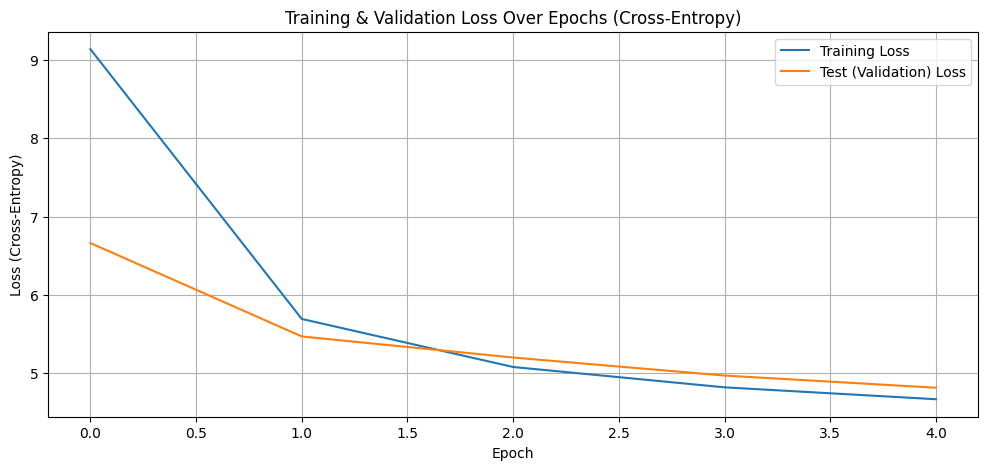

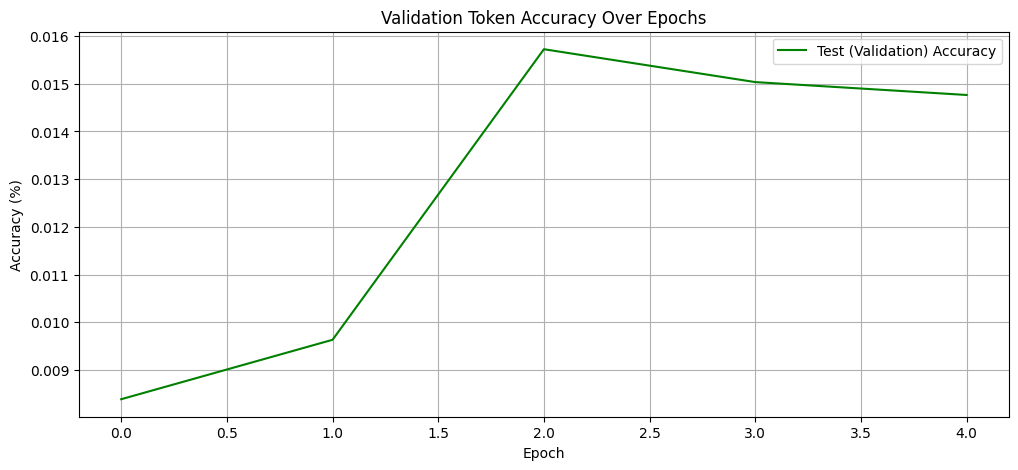

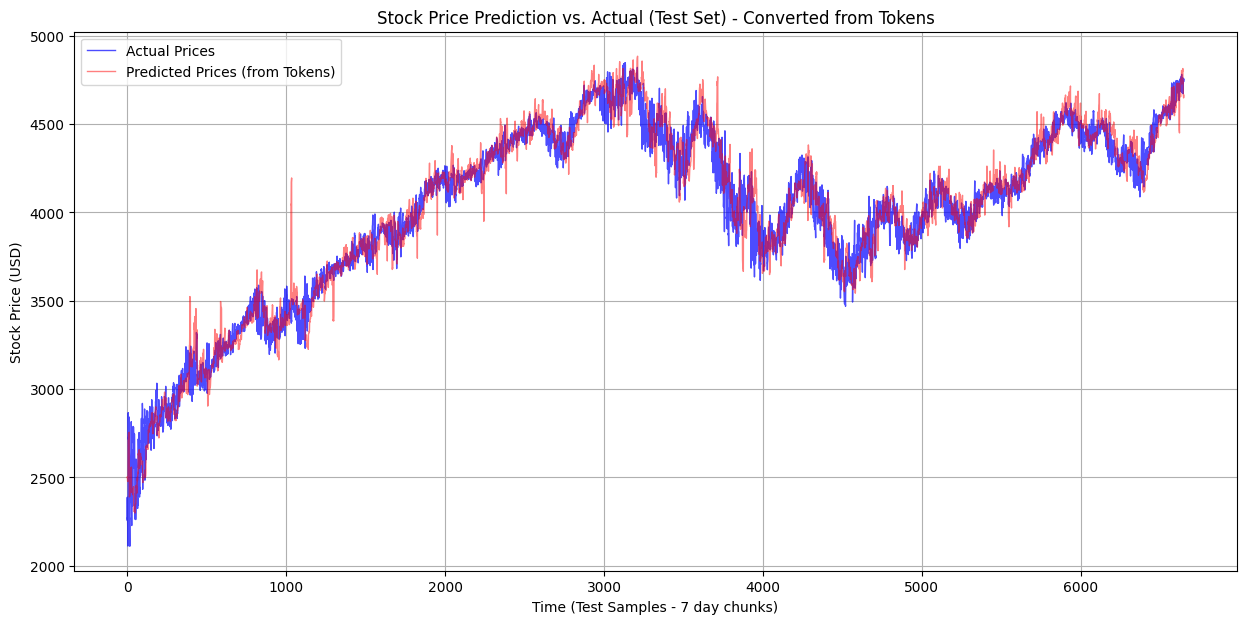

In [ ]:
# --- Plot 1: Training & Validation Loss ---
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test (Validation) Loss')
plt.title('Training & Validation Loss Over Epochs (Cross-Entropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot_token.png')
print("\n[*] Loss plot saved to loss_plot_token.png")

# --- Plot 2: Validation Accuracy ---
plt.figure(figsize=(12, 5))
plt.plot(test_accuracies, label='Test (Validation) Accuracy', color='green')
plt.title('Validation Token Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot_token.png')
print("\n[*] Accuracy plot saved to accuracy_plot_token.png")


# --- Helper function to convert log returns back to prices (same as before) ---
@jax.jit
def convert_lr_to_prices(log_returns, anchor_prices):
    """
    Converts log returns back to prices using an anchor price.
    log_returns: array of shape [batch_size, seq_len]
    anchor_prices: array of shape [batch_size, 1]
    """
    returns = jnp.exp(log_returns)
    cumulative_returns = jnp.cumprod(returns, axis=1)
    prices = anchor_prices * cumulative_returns
    return prices


# --- Plot 3: Actual vs. Predicted Prices (from Tokens) ---
# 1. Get all predictions from the testloader
all_predicted_tokens = []
all_actual_tokens = []
all_anchor_prices = []

testloader_for_plotting = DataLoader(ds.testloader.dataset, batch_size=64, shuffle=False)
eval_rng = jax.random.PRNGKey(SEED + 1)
cluster_centers_detokeniser = ds.cluster_centers # Get the "vocabulary"

print("[*] Generating token predictions for plotting...")
for inputs_tuple, target_tokens in tqdm(testloader_for_plotting):
    input_tokens_jnp = jnp.array(inputs_tuple[0].numpy(), dtype=jnp.int32) # Input tokens
    anchors_jnp = jnp.array(inputs_tuple[1].numpy())    # Anchor prices
    target_tokens_jnp = jnp.array(target_tokens.numpy(), dtype=jnp.int32) # Target tokens

    # Get logits from the model
    logits = forward.apply(state.params, eval_rng, input_tokens_jnp) # Shape [batch, 7, 128]

    # Get predicted tokens
    predicted_tokens = jnp.argmax(logits, axis=-1) # Shape [batch, 7]

    all_predicted_tokens.append(predicted_tokens)
    all_actual_tokens.append(target_tokens_jnp)
    all_anchor_prices.append(anchors_jnp)

# Concatenate all batches
all_predicted_tokens = jnp.concatenate(all_predicted_tokens, axis=0)
all_actual_tokens = jnp.concatenate(all_actual_tokens, axis=0)
all_anchor_prices = jnp.concatenate(all_anchor_prices, axis=0)

# 2. De-tokenise: Convert token indices back to log return values
# --- This now works because cluster_centers_detokeniser is (128,) ---
# --- and all_predicted_tokens is (950, 7), so the result is (950, 7) ---
preds_lr_unscaled = cluster_centers_detokeniser[all_predicted_tokens]
actuals_lr_unscaled = cluster_centers_detokeniser[all_actual_tokens]

# 3. Convert Log Returns to Prices
# Reshape anchor prices to [num_samples, 1] for broadcasting
all_anchor_prices_expanded = all_anchor_prices[:, None]

# --- This broadcast now works: (950, 1) * (950, 7) ---
actual_prices = convert_lr_to_prices(actuals_lr_unscaled, all_anchor_prices_expanded)
predicted_prices = convert_lr_to_prices(preds_lr_unscaled, all_anchor_prices_expanded)

# 4. Flatten for plotting
actual_prices_flat = actual_prices.flatten()
predicted_prices_flat = predicted_prices.flatten()

# 5. Create the plot
plt.figure(figsize=(15, 7))
plt.plot(actual_prices_flat, label='Actual Prices', color='blue', alpha=0.7, linewidth=1.0)
plt.plot(predicted_prices_flat, label='Predicted Prices (from Tokens)', color='red', alpha=0.5, linewidth=1.0)
plt.title('Stock Price Prediction vs. Actual (Test Set) - Converted from Tokens')
plt.xlabel('Time (Test Samples - 7 day chunks)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig('prediction_plot_token.png')
print("[*] Prediction plot saved to prediction_plot_token.png")